In [1]:
# Import the libraries.

import pandas as pd
import zipfile
import kaggle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.api as sms
import scipy.stats as stats

In [2]:
# Download the dataset "Wine Reviews" from Kaggle, it will download a zip file.

!kaggle datasets download -d zhangluyuan/ab-testing

Dataset URL: https://www.kaggle.com/datasets/zhangluyuan/ab-testing
License(s): unknown
ab-testing.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Extract the content from the zip file.

zipfile_name = 'ab-testing.zip'
with zipfile.ZipFile(zipfile_name, 'r') as file:
    file.extractall()

In [4]:
# Read in the csv as a pandas dataframe.

df = pd.read_csv('ab_data.csv')

In [5]:
# Explore the data (part 1). 
# As far as we can see, the dataframe contains the following columns: user_id, timestamp, group, landing_page, converted.

df.sample(10)

,user_id,timestamp,group,landing_page,converted
44110,877732,2017-01-09 16:39:32.144530,treatment,new_page,0
290323,736949,2017-01-21 10:30:58.490862,control,old_page,0
176712,923325,2017-01-14 13:36:57.384554,treatment,new_page,0
221150,861317,2017-01-20 13:01:02.165411,control,old_page,0
66454,718909,2017-01-20 13:44:17.099650,treatment,new_page,0
155053,870020,2017-01-15 23:19:08.870264,control,old_page,0
215548,833060,2017-01-09 20:27:41.283798,treatment,new_page,0
123125,765952,2017-01-23 07:45:04.615231,control,old_page,0
135323,694997,2017-01-21 20:39:11.293735,treatment,new_page,0
278704,673045,2017-01-08 15:19:19.372074,control,old_page,1


In [6]:
# Explore shape of the dataframe: 294,478 rows and 5 columns.

df.shape

(294478, 5)

In [7]:
# The key insight of this code is that the number of rows (294,478) is greater than the number of unique users (290,584). That means some users appear more than once.
# In an A/B test, each user should only be in one group, so duplicate users can bias the results.

df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [8]:
# There's no null values.

df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
# The next it's the information of the whole dataframe.
# The content of the 5 columns are the following:
# 'user_id' contains user ids
# 'timestamp' is about when a session was
# 'group' contains 2 variables: control and treatment
# 'landing_page' is about what version of a site a user saw
# 'converted' says us about user's behavior: if a user made a purchase (1) or not (0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
# The following code shows some mismatches; control group should only the old page and treatment group should only see the new page.

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [11]:
# Align groups to their specific landing pages.

df_clean = df[
    ((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))
]

In [12]:
# Validate the groups are correctly align.

pd.crosstab(df_clean['group'], df_clean['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


In [13]:
# Align groups helped with the duplicates, despite there's just one another duplicate.

df_clean[['user_id','timestamp']].nunique()

user_id      290584
timestamp    290585
dtype: int64

In [14]:
# The one that has more that one occurance it is the duplicated one.

df_clean.user_id.value_counts()

user_id
773192    2
851104    1
688307    1
718297    1
838144    1
         ..
755610    1
804629    1
837875    1
889019    1
715931    1
Name: count, Length: 290584, dtype: int64

In [15]:
# Get the index of the duplicate. 

session_counts = df_clean.user_id.value_counts()
double_users = session_counts[session_counts>1].index

double_users

Index([773192], dtype='int64', name='user_id')

In [16]:
# Remove the duplicate.

df_clean = df_clean[~df_clean['user_id'].isin(double_users)]
df_clean.shape

(290583, 5)

In [17]:
# View of the df ab_test.

df_clean.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [18]:
# Validate the number of samples for each group.

df_clean.group.value_counts()

group
treatment    145309
control      145274
Name: count, dtype: int64

In [19]:
# Balance number of samples of each group.

treatment_group = df_clean[df_clean['group'] == 'treatment'] # Filter treatment group
treatment_trimmed = treatment_group.iloc[35:]    # Remove the first 35 values of treatment group
control_group = df_clean[df_clean['group'] == 'control']     # Filter control group
ab_test = pd.concat([control_group, treatment_trimmed], axis=0)
ab_test.reset_index(inplace=True, drop=True)

In [20]:
# Validate the number of samples for each group.

ab_test.group.value_counts()

group
control      145274
treatment    145274
Name: count, dtype: int64

In [21]:
# The control group shows 12.0% conversion rate and the treatment group 11.9% conversion rate.

conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=1)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=1)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

/var/folders/_4/yjfxm4z91c16k9w6fph_q_2w0000gn/T/ipykernel_93705/3228228744.py:8: FutureWarning: The provided callable <function mean at 0x1085bf4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.324,0.001


In [22]:
# Count the number of occurrences of each group.

total_counts = ab_test.groupby('group')['converted'].count()
print(total_counts)

group
control      145274
treatment    145274
Name: converted, dtype: int64


In [23]:
# Count the number of users converted (1) with method sum.

conversion_counts = ab_test.groupby('group')['converted'].sum()
print(conversion_counts)

group
control      17489
treatment    17258
Name: converted, dtype: int64


In [52]:
# Interpretation:
# The p-value of 0.1866 is greater than the significance level of 0.05,
# so we fail to reject the null hypothesis. This suggests that the
# observed difference in conversion rates between groups A and B is not statistically significant.

z_stat, p_val = proportions_ztest(count=conversion_counts.values, nobs=total_counts.values)
print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_val:.4f}")

Z-statistic: 1.321
P-value: 0.1866


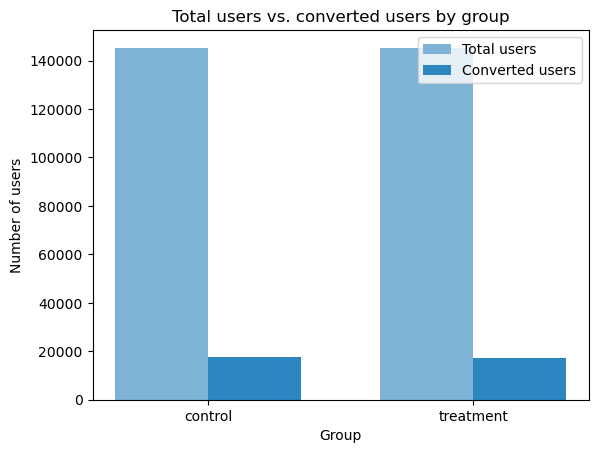

In [54]:
# Count users per group.

group_counts = ab_test['group'].value_counts().sort_index()
conversion_counts = ab_test[ab_test['converted'] == 1]['group'].value_counts().sort_index()

# Creat positions in X axis per bar.

x = np.arange(len(group_counts))  # [0, 1] for A and B groups
width = 0.35  # Width for each bar

# Graph bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, group_counts.values, width, label='Total users', color='#7FB3D5')     
bars2 = ax.bar(x + width/2, conversion_counts.values, width, label='Converted users', color='#2E86C1')  

# Labels and ticks

ax.set_xticks(x)
ax.set_xticklabels(group_counts.index)
ax.set_xlabel('Group')
ax.set_ylabel('Number of users')
ax.set_title('Total users vs. converted users by group')
ax.legend()

plt.show()